# Plotting figures for fidelity estimation project

This notebook contains functions to recreate the plots included in the PRL & PRA submissions.\
Note that these functions simply use the data that has already been computed and plots them.\
Each plot is displayed inline.

> A small module called `draw_plots`, based on `matplotlib`, has been written for the purpose of plotting.\
This module simplifies plotting and lends uniformity across plots.\
A Jupyter notebook called `plot_manager_preview` in the `examples` directory gives some basic examples on how to use this module more generally.

## Plot 1: Histogram of estimates given by the minimax method

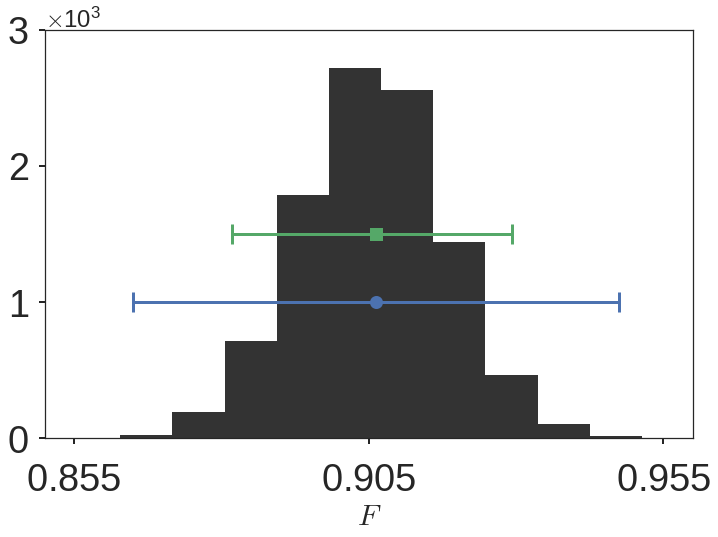

In [1]:
import numpy as np
import json
from pathlib import Path, PurePath

import project_root # adds the root of the project to the Python Path
from src.utilities.draw_plots import Plot_Manager

### function handling the plotting
def plot_JN_estimates_histogram(dirpath = './Data/', filename = 'fidelity_estimate_hist_confidence_interval_nq_4_N_192_Rlist_100_Ntest_1e4_numpovmlist_16.json',\
                                fig_dirpath = './Images/',figname = 'fidelity_estimate_hist_confidence_interval_nq_4_N_192_Rlist_100_Ntest_1e4_numpovmlist_16',\
                                fig_format = 'pdf', save_plot = False, return_plot_manager = False):
    """
        Plots the histogram of fidelity estimates obtained from Juditsky & Nemirovski's (JN) method,
        aka minimax method. Also, plotted are the JN risk and the "ideal" (asymmetric) risk.

        Data for nq = 4 qubit random target state, 10% depolarizing noise,
        N = 192 Pauli measurements with largest Flammia & Liu weights, and 100 repetitions are used.
        A total of 10^4 estimates were generated. The JN risk corresponds to a confidence level of 95%.

        Save the plot (if save_plot is True) to the location specified by fig_dirpath and figname.
    """
    ### parse the data
    # obtain quantities necessary for making the plot from the data file
    # pathlib handles removing any additional "spurious" forward slashes: https://docs.python.org/3/library/pathlib.html
    current_dir_absolute_path = Path('.').resolve()
    filepath = PurePath('%s/%s/%s' %(current_dir_absolute_path, dirpath, filename))
    with open(filepath, 'r') as datafile:
        data_dict = json.load(datafile)

    try:
        F_actual = data_dict['F_actual']
        F_estimates_list = data_dict['F_estimate']
        JN_risk = data_dict['JN_risk']
        CI_estimate_asymm = data_dict['CI_estimate']
        CI_estimate_symm = data_dict['CI_symm_estimate']
    except KeyError:
        raise ValueError("Please ensure that the correct data file has been provided")
    # discard (potentially large) data_dict
    del data_dict

    # get parameters (used to generate the data) required for making the plot
    params_filepath = PurePath('%s/%s/%s_params' %(current_dir_absolute_path, dirpath,\
                                                    filename.rstrip('.json'))).with_suffix('.json')
    with open(params_filepath, 'r') as datafile:
        params_dict = json.load(datafile)

    try:
        N_samples = params_dict['N_test']
    except KeyError:
        raise ValueError("Please ensure that the correct data file has been provided")
    # discard (potentially large) params_dict
    del params_dict

    ### draw the plot
    plot_manager = Plot_Manager()
    # histogram of fidelity estimates
    plot_manager.add_data(plot_type = 'histogram', ydata = F_estimates_list, alpha = 0.8)
    # true fidelity with Juditsky & Nemirovski risk
    plot_manager.add_data(plot_type = 'errorbar', xdata = [F_actual], ydata = [0.1*N_samples],\
                          xerr = [[JN_risk], [JN_risk]], marker = 'o', markersize = 10, markeredgewidth = 3,\
                          linewidth = 3, capsize = 10)
    # true fidelity with estimated "ideal" (asymmetric) confidence interval
    plot_manager.add_data(plot_type = 'errorbar', xdata = [F_actual], ydata = [0.15*N_samples],\
                          xerr = [[CI_estimate_asymm[0]], [CI_estimate_asymm[1]]], marker = 's',\
                          markersize = 10, markeredgewidth = 3, linewidth = 3, capsize = 10)
    plot_manager.draw_plots(figsize = (12, 9), xlabel = r'$F$', ylabel = '', xlim = [0.85, 0.96], ylim = [0, 3e3],\
                            xticks = [0.855, 0.905, 0.955], show_fig = False, save_fig = save_plot,\
                            filename = figname, dirname = fig_dirpath, fig_format = fig_format)

    if return_plot_manager:
        return plot_manager

### draw the plot
plot_JN_estimates_histogram()

## Plot 2: Variation of risk with number of measurement settings and number of repetitions

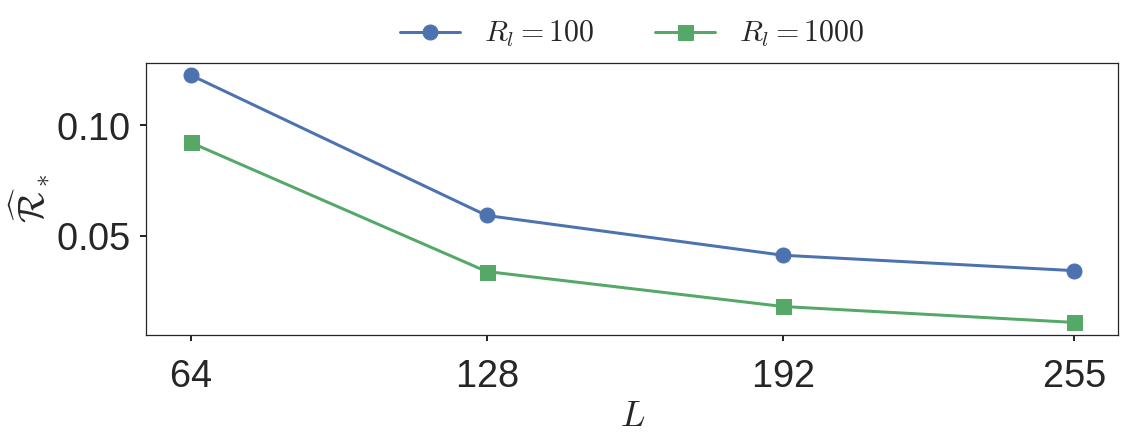

In [2]:
import numpy as np
import json
from pathlib import Path, PurePath

import project_root # adds the root of the project to the Python Path
from src.utilities.draw_plots import Plot_Manager

### function handling the plotting
def plot_risk_trend(plot_type = 'num_meas', dirpath = './Data/',\
                    filename = 'fidelity_risk_analysis_nq_4_numpovm_16.json',\
                    fig_dirpath = './Images/', figname = 'fidelity_risk_analysis_nq_4_numpovm_16',\
                    fig_format = 'pdf', save_plot = False, return_plot_manager = False):
    """
        Plots the variation of Juditsky & Nemirovski risk with the number of types of measurements
        and the number of repetitions for each type of measurement.

        plot_type: Decides what to plot on the axes
                    -'num_meas': risk vs number of types of measurements for each repetition
                    -'all_data': risk vs total size of data (i.e., number of types of measurements multiplied
                                 with the number of repetitions) for each repetition
    """
    ### parse the data
    # obtain quantities necessary for making the plot from the data file
    # pathlib handles removing any additional "spurious" forward slashes: https://docs.python.org/3/library/pathlib.html
    current_dir_absolute_path = Path('.').resolve()
    filepath = PurePath('%s/%s/%s' %(current_dir_absolute_path, dirpath, filename))
    with open(filepath, 'r') as datafile:
        data_dict = json.load(datafile)

    try:
        risk_list = data_dict['JN_risk_list']
    except KeyError:
        raise ValueError("Please ensure that the correct data file has been provided")
    # discard (potentially large) data_dict
    del data_dict

    # get parameters (used to generate the data) required for making the plot
    params_filepath = PurePath('%s/%s/%s_params' %(current_dir_absolute_path, dirpath,\
                                                    filename.rstrip('.json'))).with_suffix('.json')
    with open(params_filepath, 'r') as datafile:
        params_dict = json.load(datafile)

    try:
        # get the N and R_list values used
        N_variation = params_dict['N_variation']
        R_list_variation = params_dict['R_list_variation']
        # also get the dimension of the system
        n = int(params_dict['n'])
        # check if we are using pauli measurements
        pauli = params_dict['pauli']
    except KeyError:
        raise ValueError("Please ensure that the correct data file has been provided")
    # discard (potentially large) params_dict
    del params_dict

    # risk variation with N for different R_list values
    risk_N_variation = [[risk_list[len(R_list_variation)*i + j] for i in range(len(N_variation))]\
                            for j in range(len(R_list_variation))]

    # we are using Pauli measurements, but we don't measure the identity so if even if 4^n was specified for N, only 4^n - 1 were actually measured
    # the exception being that pauli is a list, in which case we can choose to measure the identity
    if pauli and np.max(N_variation) == n**2:
        if type(pauli) not in [list, tuple, np.ndarray]:
            max_location = np.where(np.array(N_variation) == np.max(N_variation))[0][0]
            N_variation[max_location] = N_variation[max_location] - 1
        else:
            N_variation = N_variation
    else:
        N_variation = N_variation

    ### draw the plot
    plot_manager = Plot_Manager()

    marker_list = ['o', 's', 'D', '^', 'P', 'X']
    if len(R_list_variation) > len(marker_list):
        raise ValueError("More R_list values than markers provided")

    if str(plot_type).lower() == 'num_meas':
        # plot the risk vs N for each R_list value
        for (i, Ri) in enumerate(R_list_variation):
            plot_manager.add_data(xdata = N_variation, ydata = risk_N_variation[i], xlabel = r'$L$',\
                                  ylabel = r'$\widehat{\mathcal{R}}_*$', xlabel_size = 36, ylabel_size = 36,\
                                  xticks = N_variation, label = r'$R_l = %d$' %Ri, marker = marker_list[i])
    elif str(plot_type).lower() == 'all_data':
        # plot the risk vs N * R_list for each R_list value; note that R_list is an integer here (i.e., every type of measurement is repeated equally)
        N_R_list_variation = [[N*R_list for N in N_variation] for R_list in R_list_variation]
        N_R_list_variation_ticks = [N_R_list_variation[0][0]] + N_R_list_variation[1]
        for (i, Ri) in enumerate(R_list_variation):
            plot_manager.add_data(xdata = N_R_list_variation[i], ydata = risk_N_variation[i],\
                                  xlabel = r'$L R$', ylabel = r'$\widehat{\mathcal{R}}_*$',\
                                  xticks = N_R_list_variation_ticks, label = r'$R_l = %d$' %Ri,\
                                  marker = marker_list[i])
    plot_manager.draw_plots(color_cycle = 'seaborn',  legend = 'pretty', show_fig = False, save_fig = save_plot,\
                            filename = figname, dirname = fig_dirpath, fig_format = fig_format)

    if return_plot_manager:
        return plot_manager

### draw the plot
plot_risk_trend()

## Plot 3: Plot of coverage probability v/s average bound width for PL and SDP

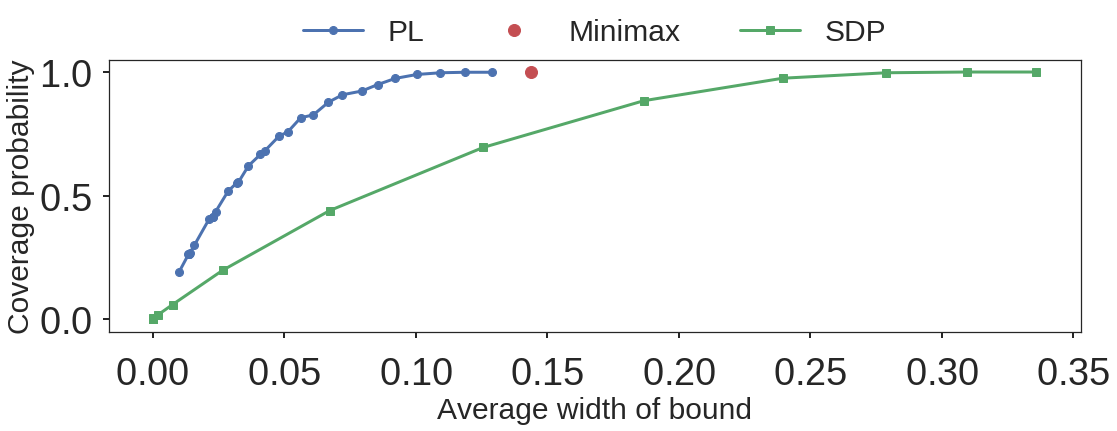

In [3]:
import numpy as np
import json
from pathlib import Path, PurePath

import project_root # adds the root of the project to the Python Path
from src.utilities.draw_plots import Plot_Manager

### function handling the plotting
def plot_fidelity_bounds_pl_jn_sdp_roc(sdp_dirpath = './Data/', sdp_filename = 'fidelity_bounds_roc_random_state_nq_3_avgwidth_coverageprob.json',\
                                       pl_dirpath = './Data/', pl_filename = 'profile_likelihood_fidelity_roc_random_state_nq_3_Nsamples_1e3_numpovmlist_16.json',\
                                       jn_dirpath = './Data/', jn_filename = 'jn_estimator_coverageprob_pl_data_random_state_nq_3_Nsamples_1e3_numpovmlist_16.json',\
                                       fig_dirpath = './Images/', figname = 'pl_jn_sdp_1e3samples_roc',\
                                       fig_format = 'pdf', save_plot = False, return_plot_manager = False):
    """
        Plots an ROC plot for fidelity bounds obtained from SDP approach and Profile Likelihood on the same plot.
        
        A data point from Juditsky & Nemirovski's estimator is also added to the plot.
    """
    ### parse the data
    # obtain quantities necessary for making the plot from the data file
    # pathlib handles removing any additional "spurious" forward slashes: https://docs.python.org/3/library/pathlib.html
    current_dir_absolute_path = Path('.').resolve()
    sdp_filepath = PurePath('%s/%s/%s' %(current_dir_absolute_path, sdp_dirpath, sdp_filename))
    with open(sdp_filepath, 'r') as datafile:
        sdp_data_dict = json.load(datafile)

    try:
        sdp_average_F_width_list = sdp_data_dict['average_F_width_list']
        sdp_coverage_prob_list = sdp_data_dict['coverage_prob']
    except KeyError:
        raise ValueError("Please ensure that the correct data file has been provided")
    # discard (potentially large) sdp_data_dict
    del sdp_data_dict

    pl_filepath = PurePath('%s/%s/%s' %(current_dir_absolute_path, pl_dirpath, pl_filename))
    with open(pl_filepath, 'r') as datafile:
        pl_data_dict = json.load(datafile)

    try:
        pl_average_F_width_list = pl_data_dict['average_width_list']
        pl_coverage_prob_list = pl_data_dict['coverage_prob_list']
    except KeyError:
        raise ValueError("Please ensure that the correct data file has been provided")
    # discard (potentially large) pl_data_dict
    del pl_data_dict

    jn_filepath = PurePath('%s/%s' %(jn_dirpath, jn_filename))
    with open(jn_filepath, 'r') as datafile:
        jn_data_dict = json.load(datafile)

    try:
        jn_confidence_interval = [2 * float(jn_data_dict['risk'])]
        jn_coverage_prob       = [float(jn_data_dict['coverage_prob'])]
    except KeyError:
        raise ValueError("Please ensure that the correct data file has been provided")
    # discard (potentially large) jn_data_dict
    del jn_data_dict
    
    ### draw the plot
    plot_manager = Plot_Manager()

    # color cycle same as seaborn but with a different positioning of colors
    color_cycle = ['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD']

    plot_manager.add_data(xdata = pl_average_F_width_list, ydata = pl_coverage_prob_list, marker = 'o',\
                          markersize = 8, label = 'PL')
    plot_manager.add_data(plot_type = 'discrete', xdata = jn_confidence_interval, ydata = jn_coverage_prob,\
                          marker = '*', markersize = 12, label = 'Minimax')
    plot_manager.add_data(xdata = sdp_average_F_width_list, ydata = sdp_coverage_prob_list, marker = 's',\
                          markersize = 8, label = 'SDP')
    plot_manager.draw_plots(xlabel = 'Average width of bound', ylabel = 'Coverage probability',\
                            color_cycle = color_cycle, legend = 'pretty', show_fig = False, save_fig = save_plot,\
                            filename = figname, dirname = fig_dirpath, fig_format = fig_format)

    if return_plot_manager:
        return plot_manager
    
### draw the plot
plot_fidelity_bounds_pl_jn_sdp_roc()